In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,Dense

In [2]:
!wget https://github.com/ronva-h/hows-my-tweet/blob/master/twitter_sentiments_data.csv.zip?raw=true -O twitter_sentiments_data.csv.zip
!unzip twitter_sentiments_data.csv.zip
!rm twitter_sentiments_data.csv.zip

--2021-12-16 05:48:44--  https://github.com/ronva-h/hows-my-tweet/blob/master/twitter_sentiments_data.csv.zip?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ronva-h/hows-my-tweet/raw/master/twitter_sentiments_data.csv.zip [following]
--2021-12-16 05:48:45--  https://github.com/ronva-h/hows-my-tweet/raw/master/twitter_sentiments_data.csv.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ronva-h/hows-my-tweet/master/twitter_sentiments_data.csv.zip [following]
--2021-12-16 05:48:45--  https://raw.githubusercontent.com/ronva-h/hows-my-tweet/master/twitter_sentiments_data.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com 

In [3]:
!wget https://github.com/ronva-h/hows-my-tweet/blob/master/twitter_sentiments_evaluation.csv.zip?raw=true -O twitter_sentiments_evaluation.csv.zip 
!unzip twitter_sentiments_evaluation.csv.zip
!rm twitter_sentiments_evaluation.csv.zip

--2021-12-16 05:48:52--  https://github.com/ronva-h/hows-my-tweet/blob/master/twitter_sentiments_evaluation.csv.zip?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ronva-h/hows-my-tweet/raw/master/twitter_sentiments_evaluation.csv.zip [following]
--2021-12-16 05:48:52--  https://github.com/ronva-h/hows-my-tweet/raw/master/twitter_sentiments_evaluation.csv.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ronva-h/hows-my-tweet/master/twitter_sentiments_evaluation.csv.zip [following]
--2021-12-16 05:48:52--  https://raw.githubusercontent.com/ronva-h/hows-my-tweet/master/twitter_sentiments_evaluation.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting

In [4]:
local_file="twitter_sentiments_data.csv"
df = pd.read_csv(local_file)
df = pd.DataFrame(df, columns=['target', 'tweet'])
df.head()

,target,tweet
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,"@nationwideclass no, it's not behaving at all...."
3,0,@Kwesidei not the whole crew
4,0,Need a hug


In [63]:
eval_file="twitter_sentiments_evaluation.csv"
df_eval_og = pd.read_csv(eval_file)
eval_tweet_index = df_eval_og['tweet_index'].tolist()
df_eval = pd.DataFrame(df_eval_og, columns=['target', 'tweet'])
df_eval.head()

,target,tweet
0,NaN,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NaN,my whole body feels itchy and like its on fire
2,NaN,Doesnt want to leave i should just move here...
3,NaN,May máº¯n sáº½ Ä‘áº¿n bÃªn em mÃ khÃ´ng cÃ³ anh
4,NaN,@LOLTrish hey long time no see! Yes.. Rains a...


In [6]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    sentence = remove_tags(sen)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [34]:
X = []
sentences = list(df['tweet'])
for sen in sentences:
    X.append(preprocess_text(sen))
y=np.array(df['target'])

X_eval = []
sentences_eval = list(df_eval['tweet'])
for sen in sentences_eval:
    X_eval.append(preprocess_text(sen))
y_eval=np.array(df_eval['target'])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_eval = tokenizer.texts_to_sequences(X_eval)

In [36]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_eval = pad_sequences(X_eval, padding='post', maxlen=maxlen)

In [18]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-12-16 05:59:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-16 05:59:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-16 05:59:58--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [21]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [22]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [23]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(rate=0.5)) # Avoid overfitting
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [24]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
6551/6551 [==============================] - 76s 10ms/step - loss: 0.5235 - acc: 0.7410 - val_loss: 0.4844 - val_acc: 0.7719
Epoch 2/6
6551/6551 [==============================] - 60s 9ms/step - loss: 0.4949 - acc: 0.7633 - val_loss: 0.4691 - val_acc: 0.7810
Epoch 3/6
6551/6551 [==============================] - 64s 10ms/step - loss: 0.4856 - acc: 0.7691 - val_loss: 0.4623 - val_acc: 0.7855
Epoch 4/6
6551/6551 [==============================] - 64s 10ms/step - loss: 0.4800 - acc: 0.7734 - val_loss: 0.4593 - val_acc: 0.7866
Epoch 5/6
6551/6551 [==============================] - 60s 9ms/step - loss: 0.4756 - acc: 0.7766 - val_loss: 0.4573 - val_acc: 0.7877
Epoch 6/6
6551/6551 [==============================] - 64s 10ms/step - loss: 0.4725 - acc: 0.7783 - val_loss: 0.4561 - val_acc: 0.7904


In [25]:
score = model.evaluate(X_test, y_test, verbose=1)

8189/8189 [==============================] - 28s 3ms/step - loss: 0.4571 - acc: 0.7902


In [ ]:
# y = (model.predict(X_test) > 0.5).astype("int32")
# y=list(np.concatenate(y))

In [43]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_bool = (y_pred > 0.5).astype("int32")

print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79    130981
           1       0.80      0.78      0.79    131041

    accuracy                           0.79    262022
   macro avg       0.79      0.79      0.79    262022
weighted avg       0.79      0.79      0.79    262022



In [68]:
y_pred_eval = model.predict(X_eval)
y_pred_eval_bool = (y_pred_eval > 0.5).astype("int32")
eval_pred_list = list(np.squeeze(y_pred_eval_bool))

In [72]:
import csv
with open('eval_2.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["tweet_index", "target"])
    writer.writerows(zip(eval_tweet_index, eval_pred_list))

Test Score: 0.4571322202682495
Test Accuracy: 0.7901512384414673


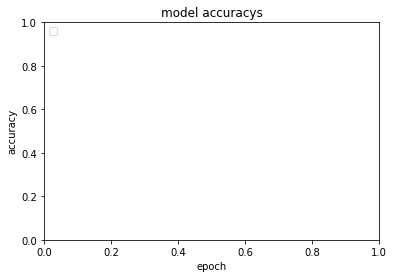

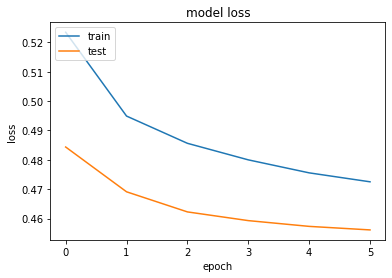

In [27]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.title('model accuracys')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [29]:
# df=pd.DataFrame({'tweet_id':sentence,'target':res})